In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [11]:
def get_waiting_time(min_wait_time, anom_diff_exp,check=0):
    
    R = np.random.uniform(0,1)
    waiting_time = min_wait_time / (R**(1/anom_diff_exp))
    
    return waiting_time

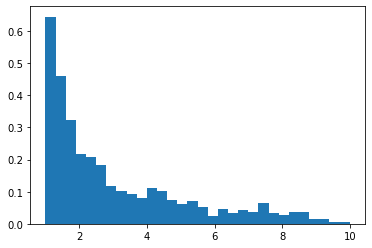

In [12]:
def check_waiting_times(nsamples,alpha,min_waiting_time=1):
    # plotting probability distribution of waiting times as a check
    waiting_times = np.empty((nsamples))
    for i in range(nsamples):
        waiting_times[i] = get_waiting_time(min_waiting_time, alpha)
    plt.hist(waiting_times, bins=30, range=(A, 10), density=True)
    
check_waiting_times(1000,0.5)

In [15]:
def gaussian_step(D, t, ndim=1):
    
    var = 2*ndim*D*t
    dx = np.random.normal(scale=np.sqrt(var))
    return dx

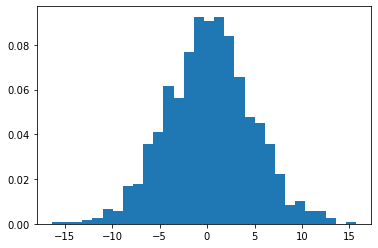

In [17]:
def check_steps(nsamples,D_coeff,t):
    # plotting probability distribution of step lengths as a check

    step_lengths = np.empty((nsamples))
    for i in range(nsamples):
        step_lengths[i] = gaussian_step(D_coeff, t)
    plt.hist(step_lengths, bins=30, density=True)
    
check_steps(1000,10,1)

In [36]:
# CTRW for single particle in 1D
def ctrw(x_start, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,plot=0):
    """
    Be consistent with units
    run_time: simulation time 
    diff_time: diffusion time
    min_wait_time: minimum waiting time
    """
    time = 0
    x = x_start
    times = np.array([time])
    xs = np.array([x])
    while time < run_time:
        waiting_time = get_waiting_time(min_wait_time, anom_diff_exp)
        time += waiting_time  # update current time
        times = np.append(times, time)
        xs = np.append(xs, xs[-1])
        x += gaussian_step(diff_coeff, diff_time)  # update current x position
        times = np.append(times, time)
        xs = np.append(xs, x)
    
    times = times[:-1]
    xs = xs[:-1]
    
    times = np.append(times, run_time)
    xs = np.append(xs, xs[-1])
    
    data = {'t': times, 'x': xs}
    df = pd.DataFrame(data)
    if plot==1:
        plt.plot(df['t'], df['x'])
    return df

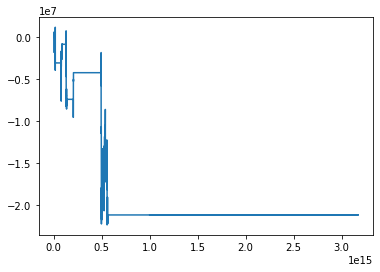

In [38]:
# what units is DaMaRiS diffusion coefficient in?
# times in ps:
df = ctrw(0, 2.8e11, 1, 1e15, 1e9, 0.5,plot=1)

In [40]:
def ctrw_3d(initial_position, diff_coeff, diff_time, run_time, min_wait_time, anom_diff_exp,plot=0):
    """
    """
    time = 0
    x, y, z = initial_position
    times = np.array([time])
    xs = np.array([x])
    ys = np.array([y])
    zs = np.array([z])
    
    while time < run_time:
        waiting_time = get_waiting_time(min_wait_time, anom_diff_exp)
        time += waiting_time  # update current time
        times = np.append(times, time)
        xs = np.append(xs, xs[-1])
        ys = np.append(ys, ys[-1])
        zs = np.append(zs, zs[-1])
        x += gaussian_step(diff_coeff, diff_time)  # update current x position
        y += gaussian_step(diff_coeff, diff_time)  # update current y position
        z += gaussian_step(diff_coeff, diff_time)  # update current z position
        times = np.append(times, time)
        xs = np.append(xs, x)
        ys = np.append(ys, y)
        zs = np.append(zs, z)
    
    data = {'t': times, 'x': xs, 'y': ys, 'z': zs}
    df = pd.DataFrame(data)
                      
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df_3d['x'], df_3d['y'], df_3d['z'])
    return df

In [41]:
df_3d = ctrw_3d((0,0,0), 2.8e11, 1, 1e15, 1e9, 0.5)

In [226]:
def gauss_step_3d(xyz_array,diff_coeff, diff_time):
    
    new_coords = np.zeros(3)
    
    if len(xyz_array.flatten()) > 3:
        xyz_array_row = xyz_array[-1]
    else:
        xyz_array_row = xyz_array
    
    for i,x_i in enumerate(xyz_array_row):
        
        new_coords[i] = x_i + gaussian_step(diff_coeff,diff_time)
        
    xyz_array = np.vstack((xyz_array,new_coords))
    return xyz_array

def get_distance_3d(xyz_array1,xyz_array2):
    #function to get distance between two sets of coordinates
    
    distance = 0
    
    for i,x_i in enumerate(xyz_array1):
        
        distance += (x_i - (xyz_array2[i]))**2
        
    return np.sqrt(distance)

def interaction_process(p):
    #simple call to uniform function if within distance
    #could be altered to consider probability based on distance
    repair = 0 
    q = np.random.uniform(0,1)
    if q > p:
        repair = 1
    return repair

def get_halfway(xyz_array1,xyz_array2):
    
    halfway_coords = np.empty(3)
    
    for i,x_i in enumerate(xyz_array1):
        
        halfway_coords[i] = (x_i + xyz_array2[i])/2
        
    return halfway_coords


In [350]:
def ctrw_3d_interaction(initial_pos,diff_coeff,diff_time,run_time,min_wait_time,anom_diff_exp,
                        int_length,interaction_p=0.5,plot=0):
    """
    """
    repair = 0 
    time1 = 0
    time2 = 0 
    
    x1, y1, z1 = initial_pos[0]
    x2, y2, z2 = initial_pos[1]
    
    times1 = np.array([time1])
    times2 = np.array([time2])
    
    coords1 = np.array([x1, y1, z1])
    coords2 = np.array([x2, y2, z2])
    
    interaction_coords = np.array([0,0,0,0,0,0])
    interaction_times = np.array([0,0])
    interaction_count = 0
    int_count_arr = np.array(interaction_count)
    repair_arr = np.array([repair])

    while (time1 < run_time or time2 < run_time) and repair ==0:
        waiting_time1 = get_waiting_time(min_wait_time, anom_diff_exp)
        waiting_time2 = get_waiting_time(min_wait_time, anom_diff_exp)
        
        time1 += waiting_time1  # update current time
        times1 = np.append(times1, time1)
        
        time2 += waiting_time2  # update current time
        times2 = np.append(times2, time2)

        coords1 = gauss_step_3d(coords1,diff_coeff, diff_time)
        coords2 = gauss_step_3d(coords2,diff_coeff, diff_time)
        
        distance = get_distance_3d(coords1[-1],coords2[-1])
        
        if distance < int_length:
            
            interaction_count += 1
            int_coords_temp = np.append(coords1[-1],coords2[-1])
            repair = interaction_process(interaction_p)
            
            if interaction_count == 1:
                interaction_times = np.array([time1,time2])
                interaction_times = np.reshape(interaction_times,(1,len(interaction_times)))
                interaction_coords = np.reshape(int_coords_temp,(1,len(int_coords_temp)))
                int_count_arr = np.array([interaction_count])
                repair_arr = np.array([repair])
                
            else: 
                interaction_times = np.vstack((interaction_times,np.array([time1,time2])))
                interaction_coords = np.vstack((interaction_coords,int_coords_temp))
                int_count_arr = np.append(int_count_arr,interaction_count)
                repair_arr = np.append(repair_arr,repair)


    data1 = {'t': times1, 'x': coords1[:,0], 'y': coords1[:,1], 'z': coords1[:,2]}
    df1 = pd.DataFrame(data1)
    data2 = {'t': times2, 'x': coords2[:,0], 'y': coords2[:,1], 'z': coords2[:,2]}
    df2 = pd.DataFrame(data2)
    
    print(interaction_count)
    
    """
    if plot ==1:              
        %matplotlib notebook
        fig = plt.figure()
        ax = plt.axes(projection ='3d')
        ax.plot3D(df1['x'], df1['y'], df1['z'])
        ax.plot3D(df2['x'], df2['y'], df2['z'])
        ax.scatter(df1['x'].iloc[0], df1['y'].iloc[0], df1['z'].iloc[0],marker='x',c='k')
        ax.scatter(df2['x'].iloc[0], df2['y'].iloc[0], df2['z'].iloc[0],marker='x',c='k')
        
        if interaction_count > 1:
            ax.scatter(interaction_coords[:-1,0],interaction_coords[:-1,1],
                       interaction_coords[:-1,2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-1,0],interaction_coords[-1,1],
                       interaction_coords[-1,2],c='r')
                
        elif interaction_count == 1:
            ax.scatter(interaction_coords[0],interaction_coords[1],
                       interaction_coords[2],c='k')
            if repair == 1:
                ax.scatter(interaction_coords[-0],interaction_coords[1],
                       interaction_coords[2],c='r')
                       
    """
        
    return interaction_times,interaction_coords,int_count_arr,repair_arr
            

In [351]:
min_dist  = 1e7
ts,xyzs,counts,repair = ctrw_3d_interaction([(0,0,0),(0,0,min_dist*1)], 2.8e11, 1, 1e16, 1e9, 0.5,
                                   min_dist,interaction_p = 0.9,plot=1)

2


In [371]:
def ctrw_3d_interaction_mc(nsamples,initial_pos,diff_coeff,diff_time,run_time,min_wait_time,anom_diff_exp,
                        int_length,interaction_p=0.5,plot=0):
    
    for i in np.arange(nsamples):
        
        ts_temp,xyzs_temp,counts_temp,repair_temp = ctrw_3d_interaction(initial_pos, diff_coeff, diff_time, run_time, min_wait_time, 0.5,
                                                    int_length,interaction_p = 0.9,plot=1)
     
        repair_temp = np.reshape(repair_temp,(len(repair_temp),1))
        counts_temp = np.reshape(counts_temp,(len(counts_temp),1))
        
        if counts_temp[0] != 0:
        
            mc_sample = np.full((len(counts_temp),1),i)

            print(np.shape(mc_sample),np.shape(ts_temp),np.shape(xyzs_temp),np.shape(counts_temp),np.shape(repair_temp))

            data_temp = np.hstack((mc_sample,ts_temp,xyzs_temp,counts_temp,repair_temp))

            if i == 0:

                repair_data = data_temp

            else: 

                repair_data = np.vstack((repair_data,data_temp))
                
    print(np.shape(repair_data))
    repair_df = pd.DataFrame(data=repair_data, columns=['mc_step', 't1', 't2','x1','y1','z1',
                                                        'x2','y2','z2','interaction','repair'])
    
            
    return repair_df


In [373]:
repair_data = ctrw_3d_interaction_mc(3,[(0,0,0),(0,0,min_dist*1)], 2.8e11, 1, 1e16, 1e9, 0.5,
                                       min_dist,interaction_p = 0.9,plot=0)

1
(1, 1) (1, 2) (1, 6) (1, 1) (1, 1)
10
(10, 1) (10, 2) (10, 6) (10, 1) (10, 1)
12
(12, 1) (12, 2) (12, 6) (12, 1) (12, 1)
(23, 11)


In [374]:
repair_data

,mc_step,t1,t2,x1,y1,z1,x2,y2,z2,interaction,repair
0,0.0,1.976505e+10,5.469529e+10,-3.137302e+04,8.562685e+05,3.365498e+05,3.139181e+06,-1.655647e+06,9.468631e+06,1.0,1.0
1,1.0,2.121582e+09,1.160057e+09,8.734693e+05,-3.754779e+05,1.057993e+06,-1.571329e+05,4.446897e+05,9.917607e+06,1.0,0.0
2,1.0,3.290456e+09,3.013078e+09,1.559289e+06,-1.573170e+05,1.364977e+06,2.009769e+05,7.202171e+05,9.843188e+06,2.0,0.0
3,1.0,4.529622e+09,4.660919e+09,7.986097e+04,-5.292440e+05,3.502663e+05,1.185696e+05,1.095966e+06,9.407469e+06,3.0,0.0
4,1.0,7.126711e+09,5.800716e+09,-5.161077e+05,2.401182e+05,1.350174e+06,-1.032667e+06,1.441622e+06,1.006211e+07,4.0,0.0
5,1.0,8.884956e+09,2.180956e+10,1.844194e+05,-5.411942e+05,1.476870e+06,-2.115586e+06,1.745876e+06,1.036950e+07,5.0,0.0
6,1.0,1.762313e+10,5.651110e+10,-7.615922e+05,-5.863854e+05,1.197688e+06,-1.982019e+06,1.442739e+06,9.547334e+06,6.0,0.0
7,1.0,1.877802e+10,6.955822e+10,-6.005052e+05,-4.885229e+05,1.461824e+06,-2.719942e+06,7.945036e+05,8.743335e+06,7.0,0.0
8,1.0,2.441566e+10,7.414370e+10,-9.752139e+05,-4.451117e+05,1.767646e+06,-2.665818e+06,1.563314e+06,7.739911e+06,8.0,0.0
9,1.0,4.331685e+10,7.722817e+10,-5.118542e+05,-1.400552e+06,2.199773e+06,-3.328532e+06,2.174491e+06,7.557566e+06,9.0,0.0
